# Visual Transformers Training

## Including the needed libraries

In [1]:
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import tensorflow_addons as tfa
import warnings
from vit_keras import vit
from vit_keras import visualize

%matplotlib inline

warnings.filterwarnings('ignore')

2021-11-24 17:21:47.150800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 17:21:47.150854: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print('Python Version ' + sys.version)
print('TensorFlow Version ' + tf.__version__)

if int(sys.version[0]) < 3 or int(sys.version[2]) < 7:
    assert("Python version 3.7 or newer is required")
if int(tf.__version__[0]) < 2 or int(tf.__version__[2]) < 6 or int(tf.__version__[2]) > 7:
    assert("Tensorflow version 2.6 or 2.7 is required")

Python Version 3.9.0 (default, Nov 15 2020, 14:28:56) 
[GCC 7.3.0]
TensorFlow Version 2.6.2


## Setting the parameters

In [3]:
IMAGE_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 100

CUR_PATH = os.path.abspath('')
TRAIN_PATH = CUR_PATH + '/../../../dataset/data/classified'
VALID_PATH = CUR_PATH + '/../../../dataset/data/validation'
TEST_PATH = CUR_PATH + '/../../../dataset/data/test'

classes = {0 : "Baby",
           1 : "Not Baby"}

## Defining Data Augmentation Function

In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Defining Data Generators

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True)


val_test_datagen.apply_transform

train_ds = datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed = 1,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

val_ds = val_test_datagen.flow_from_directory(
        VALID_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

test_ds = val_test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        class_mode='binary')

Found 135 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


2021-11-24 17:21:55.797359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/disk/miniconda3/envs/face/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-24 17:21:55.797441: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 17:21:55.797501: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snf-22339): /proc/driver/nvidia/version does not exist
2021-11-24 17:21:55.798140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Clipping input data

(160, 160, 3)


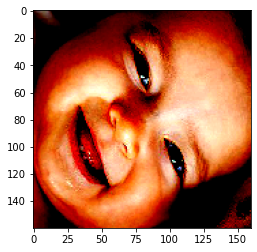

In [6]:
x = train_ds.next()
image = x[0][0]
print(image.shape)
plt.imshow(image)

In [7]:
cat_img = plt.imread(TRAIN_PATH + '/baby/1.jpeg')

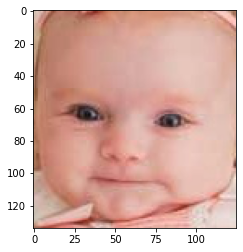

In [8]:
plt.imshow(cat_img)

## Loading the Visual Transformers Model

In [9]:
vit_model = vit.vit_b32(
    image_size = IMAGE_SIZE,
    activation = 'softmax',
    pretrained = True,
    include_top = False,
    pretrained_top = False,
    classes = 2)

## Visualizing the Attention maps

In [10]:
def vizualize():
    x = train_ds.next()
    image = x[0][0]
    print(image.shape)

    attention_map = visualize.attention_map(model = vit_model, image = image)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(ncols = 2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(((255 - attention_map)))

(160, 160, 3)


2021-11-24 17:22:21.552095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


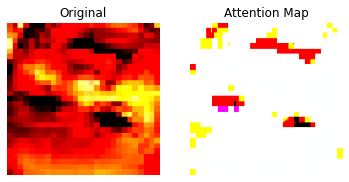

In [11]:
vizualize()

## Creating the model

In [12]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87436800  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 16)                12304     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 87,452,257
Trainable params: 87,450,689
Non-trainable params: 1,568
________________________________

## Defining Callbacks

In [13]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.binary_crossentropy, 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_ds.n // train_ds.batch_size
# STEP_SIZE_VALID = val_ds.n // val_ds.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 # verbose = 1,
                                                 factor = 0.2,
                                                 patience = 10,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'min')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 # verbose = 1,
                                                 min_delta = 1e-4,
                                                 patience = 30,
                                                 mode = 'min',
                                                 restore_best_weights = True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(monitor = 'val_loss', 
                                                  # verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'min',
                                                  filepath = './model_vit.hdf5')

callbacks = [checkpointer, reduce_lr, earlystopping] #reduce_lr earlystopping

## Training the Model

In [14]:
model.fit(x = train_ds,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_ds,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model_vit.h5')

Epoch 1/100
8/8 [==============================] - 60s 2s/step - loss: 0.7999 - accuracy: 0.5378 - val_loss: 0.6648 - val_accuracy: 0.5806
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 0.8629 - accuracy: 0.4706 - val_loss: 0.6248 - val_accuracy: 0.6129
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.7897 - accuracy: 0.5378 - val_loss: 0.5750 - val_accuracy: 0.7419
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.7409 - accuracy: 0.6218 - val_loss: 0.5262 - val_accuracy: 0.8065
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.6107 - accuracy: 0.6975 - val_loss: 0.4751 - val_accuracy: 0.8387
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 0.6364 - accuracy: 0.6723 - val_loss: 0.4278 - val_accuracy: 0.8710
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 0.5342 - accuracy: 0.7395 - val_loss: 0.3847 - val_accuracy: 0.9032
Epoch 8/100
8/8 [===============

## Evaluating the model on test set

In [15]:
# test_model = tf.keras.models.load_model("./Models/best_model.h5")

In [16]:
# test_model.evaluate(test_ds)

In [17]:
model.evaluate(test_ds)

2/2 [==============================] - 1s 100ms/step - loss: 0.1122 - accuracy: 0.9444


[0.11219920217990875, 0.9444444179534912]

In [18]:
res = model.predict(test_ds)

In [19]:
res

array([[0.90654755],
       [0.94021875],
       [0.4096046 ],
       [0.1246886 ],
       [0.9268763 ],
       [0.00120696],
       [0.9250697 ],
       [0.02701172],
       [0.00934869],
       [0.02833629],
       [0.87757194],
       [0.9488079 ],
       [0.83423406],
       [0.95818675],
       [0.00786358],
       [0.01170903],
       [0.0327681 ],
       [0.8577409 ]], dtype=float32)

In [20]:
res[res >= 0.5] = 1

In [21]:
res[res < 0.5] = 0

In [22]:
res

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.]], dtype=float32)